In [1]:
import os
import clip
import torch
import argparse
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms
from loaders import CxrDataLoader

In [2]:
CHECKPOINT_PATH = "./output"

args = argparse.Namespace(
    dataset_name='iu-xray',
    batch_size=16,
    num_workers=0,
    max_seq_length=248
)

In [3]:
model_path = os.path.join(CHECKPOINT_PATH, "best_128_5e-05_original_22000_0.855.pt")
model, preprocess = clip.load(model_path, load_from_clip=False, load_checkpoint=True)

input_resolution = model.visual.input_resolution
context_length = model.context_length
extended_context_length = model.extended_context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Original context length:", context_length)
print("Extended context length:", extended_context_length)
print("Vocab size:", vocab_size)

[Warning] Missing keys in state_dict: ['concept_embedding', 'medical_concept_classifier.model.0.weight', 'medical_concept_classifier.model.0.bias', 'medical_concept_classifier.model.3.weight', 'medical_concept_classifier.model.3.bias']
Model parameters: 151,685,391
Input resolution: 224
Original context length: 77
Extended context length: 248
Vocab size: 49408


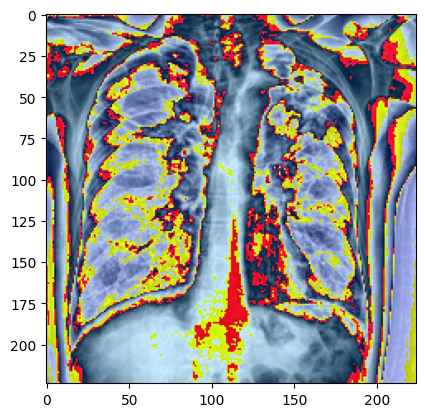

In [19]:
test_loader = CxrDataLoader(args, split='val', transform=preprocess)

test_loader_iter = iter(test_loader)
entry = next(test_loader_iter)

image = transforms.ToPILImage()(entry["image"][0])
image = image.convert("RGB")

plt.imshow(image, cmap="gray")

In [9]:
image_tensor = entry["image"][0].unsqueeze(0)
report = entry["report"][0]

proj_features, image_features = model.encode_image(image_tensor)
text_features = model.encode_text(clip.tokenize(report, extended_context=False)).float()

print(f"Image features: {proj_features.shape}")
print(f"Text features: {text_features.shape}")

proj_features /= proj_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
logit_scale = model.logit_scale.exp().clamp(max=100)
similarity = (logit_scale * (text_features @ proj_features.T)).detach().cpu().numpy()

# with torch.no_grad():
#     output = model.predict_medical_concepts(image_features)
#     probs = output["probs"]

# print(f"Image probs: {probs}")
print(f"Similarity: {similarity}")

Image features: torch.Size([1, 512])
Text features: torch.Size([1, 512])
Similarity: [[28.24706]]


Query report: 1. Bullous emphysema and interstitial fibrosis. 2. Probably scarring in the left apex, although difficult to exclude a cavitary lesion. 3. Opacities in the bilateral upper lobes could represent scarring, however the absence of comparison exam, recommend short interval followup radiograph or CT thorax to document resolution.
Query labels: tensor([ 0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.])
Candidate report: No acute cardiopulmonary findings
Candidate labels: tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
Matching pair similarity: [[29.685734]]
Non-matching pair similarity: [[16.348202]]


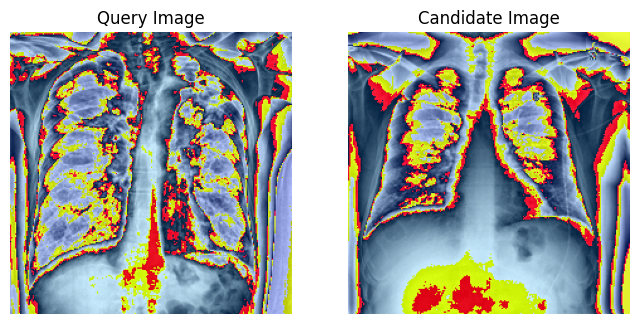

In [20]:
def select_non_matching_sample_by_labels(loader, query_labels):
    """
    Iterates over the loader to find a sample whose label tensor differs from the query sample's labels.

    Args:
        loader: A data loader that yields batches containing the key "labels".
        query_labels (torch.Tensor): The label tensor for the query sample.

    Returns:
        A sample dictionary from the loader that has different labels than the query, or None if not found.
    """
    for batch in loader:
        batch_size = len(batch["uid"])
        for i in range(batch_size):
            candidate_labels = batch["labels"][i]
            if not torch.equal(candidate_labels, query_labels):
                return { key: batch[key][i] for key in batch }
    return None

# Usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loader_iter = iter(test_loader)
query_entry = next(test_loader_iter)
query_image_tensor = query_entry["image"][0].unsqueeze(0).to(device)
query_report = query_entry["report"][0]
query_labels = query_entry["labels"][0]

print("Query report:", query_report)
print("Query labels:", query_labels)

non_matching_entry = select_non_matching_sample_by_labels(test_loader, query_labels)
if non_matching_entry is None:
    print("No non-matching sample found!")
else:
    candidate_image_tensor = non_matching_entry["image"].unsqueeze(0).to(device)
    candidate_report = non_matching_entry["report"]
    candidate_labels = non_matching_entry["labels"]
    print("Candidate report:", candidate_report)
    print("Candidate labels:", candidate_labels)

    # Encode query image and text
    proj_query, _ = model.encode_image(query_image_tensor)
    text_query = model.encode_text(clip.tokenize(query_report, extended_context=False).to(device)).float()

    proj_query /= proj_query.norm(dim=-1, keepdim=True)
    text_query /= text_query.norm(dim=-1, keepdim=True)

    logit_scale = model.logit_scale.exp().clamp(max=100)

    # Matching pair similarity (query image with its own text)
    sim_matching = (logit_scale * (text_query @ proj_query.T)).detach().cpu().numpy()

    # Encode candidate image (non-matching)
    proj_candidate, _ = model.encode_image(candidate_image_tensor)
    proj_candidate /= proj_candidate.norm(dim=-1, keepdim=True)

    sim_nonmatching = (logit_scale * (text_query @ proj_candidate.T)).detach().cpu().numpy()

    print("Matching pair similarity:", sim_matching)
    print("Non-matching pair similarity:", sim_nonmatching)

    # Optionally visualize the images
    from torchvision.transforms import ToPILImage
    import matplotlib.pyplot as plt

    query_img = ToPILImage()(query_entry["image"][0])
    candidate_img = ToPILImage()(non_matching_entry["image"])

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(query_img)
    plt.title("Query Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(candidate_img)
    plt.title("Candidate Image")
    plt.axis("off")
    plt.show()